*#*

In [5]:
# general tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import datetime as dt
import json
import requests
import scipy as sp
import numpy as np
import tempfile
import random
import time
import math
import statistics
import os
from typing import Tuple, Dict, List
import sys
import warnings
warnings.filterwarnings('ignore')

# preprocessing & utils
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ml models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# others
from wordcloud import WordCloud
from matplotlib.ticker import FormatStrFormatter

<center>
    <h3>Constant</h3>
</center>

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

<center>
    <h3>Utility Function</h3>
</center>

In [188]:
# processsing
def pipe_cleaningText(text: str) -> str:
    txt = text.lower()
    return txt

def pipe_removeStopWords(text: str, tokenized: bool = False) -> str:
    if tokenized:
        return " ".join([w for w in text.split(" ") if w not in stop_words])
    return " ".join([w for w in word_tokenize(text) if w not in stop_words])

def pipe_lemmatization(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in collections:
        txt += lemmatizer.lemmatize(w) + ' '
    return txt.strip()

def pipe_addPos(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in pos_tag(collections):
        txt += '__'.join(w) + ' '
    return txt.strip()

def pipe_normalized(text: str, bin: int, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    n = len(collections)
    for i, w in enumerate(collections):
        normVal = math.floor((i / (n - 1)) * (bin - 1)) + 1 if n != 1 else 1
        txt += w + '__' + str(normVal) + ' '
    return txt.strip()

def pipe_subjectCleaning(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = sent_tokenize(text) if not tokenized else text.split(" ")
    for s in collections:
        for w in pos_tag(word_tokenize(s)):
            if w[1] != 'NNP':
                continue
            txt += w[0] + ' '
    return txt.strip()

# feature extraction
def feature_tfidfUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

def feature_tfidfUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

# sampling
def balancing_upsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    highest_n = max(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == highest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == highest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, highest_n - group_res.loc[i], replace=True)
        thedata = pd.concat([thedata, tdata, tdata.loc[sample_ind]])
    return thedata

def balancing_downsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    lowest_n = min(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == lowest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == lowest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, lowest_n, replace=False)
        thedata = pd.concat([thedata, tdata.loc[sample_ind]])
    return thedata

# testing
def accuracyTrainTest(model, trainX: np.array, trainY: np.array, valX: np.array, valY: np.array, testX: np.array, testY: np.array) -> Tuple[float, float, float]:
    mod = model.fit(trainX, trainY)
    yfit = mod.predict(trainX)
    ypredVal = mod.predict(valX)
    ypredTest = mod.predict(testX)
    
    # train result, validation result, test result
    return accuracy_score(trainY, yfit), accuracy_score(valY, ypredVal), accuracy_score(testY, ypredTest)
    
def loop_testing(model, n_test: int, xArr: sp.sparse.csr_matrix, yArr: np.array, testXArr: sp.sparse.csr_matrix, testYArr: np.array) -> Dict[str, List[float]]:
    thedict = {}

    i = 0
    n = xArr.shape[0]
    n_sample = math.ceil(n / n_test)
    x_sam, y_sam = np.array([]), np.array([])
    while i < n_test:
        percent_sample = n_sample/xArr.shape[0]
        if percent_sample >= 1:
            xmain, ymain = xArr, yArr
        else:
            xmain, xArr, ymain, yArr = train_test_split(xArr, yArr, train_size=percent_sample, stratify=yArr, random_state=123)
        
        x_sam = sp.sparse.vstack((x_sam, xmain)) if x_sam.shape[0] != 0 else xmain
        y_sam = np.hstack((y_sam, ymain)) if y_sam.shape[0] != 0 else ymain
        xtrain, xtest, ytrain, ytest = train_test_split(x_sam, y_sam, train_size=0.9, stratify=y_sam, random_state=123)

        resTrain, resVal, resTest = accuracyTrainTest(model, xtrain, ytrain, xtest, ytest, testXArr, testYArr)
        thedict[x_sam.shape[0]] = [resTrain, resVal, resTest]

        i += 1
    return thedict

# visualization
def show_result(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Neutral', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neu', 'False Neg',
                   'False Pos', 'True Neu', 'False Neg',
                   'False Pos', 'False Neu', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(3, 3)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

# visualization
def show_result2group(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neg',
                   'False Pos', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(2,2)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def show_result5group(ypred: np.array, ytarget: np.array) -> None:
    label = [1,2,3,4,5][::-1]
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Meh-Pos', 'False Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'True Meh-Pos', 'False Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'True Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'False Neu', 'True Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'False Neu', 'False Meh-Neg', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(5, 5)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def visualized_loopTesting(result_loopTesting: Dict[str, List[float]]) -> None:
    train_res, val_res, test_res = dict(), dict(), dict()
    for res in result_loopTesting:
        train_res[res] = result[res][0]
        val_res[res] = result[res][1]
        test_res[res] = result[res][2]

    fig, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.lineplot(y=train_res.values(), x=train_res.keys() , ax=axe, label='train-result')
    sns.lineplot(y=val_res.values(), x=val_res.keys(), ax=axe, label='val-result')
    sns.lineplot(y=test_res.values(), x=test_res.keys(), ax=axe, label='test-result')
    axe.set_title("Highest Score: {}".format(max(test_res.values())))
    axe.set_xlabel("Dataset Size")
    axe.set_ylabel("Accuracy")
    axe.set_ylim([0.65, 1.0])
    axe.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.show();

# others
def correlation(x: list, y: list) -> float:
    x = np.array(x)
    y = np.array(y)
    bar_x = x.mean()
    bar_y = y.mean()
    sum_xixbar_yiybar = sum((x - bar_x) * (y - bar_y))
    sum_xixbar2 = sum((x - bar_x) ** 2)
    sum_yiybar2 = sum((y - bar_y) ** 2)

    numer = sum_xixbar_yiybar
    denom = (sum_xixbar2 * sum_yiybar2) ** (1 / 2)

    r = numer / denom if denom != 0 else 0

    return r

def gradient(x: list, y: list) -> float:
    p1 = [x[0], y[0]]
    p2 = [x[2], y[2]]

    numer = p1[1] - p2[1]
    denom = p1[0] - p2[0]

    return numer / denom
    

<center>
    <h3>Process</h3>
</center>

Goals
- Try training using binary output (1 & 5) & measure performance on all output (1 to 5)

In [10]:
df = pd.read_csv('../data/Amazon_Electronics.csv')

In [11]:
df.describe()

,overall,unixReviewTime
count,2.094154e+07,2.094154e+07
mean,4.073490e+00,1.425820e+09
std,1.385862e+00,7.772530e+07
min,1.000000e+00,8.811936e+08
25%,4.000000e+00,1.393891e+09
50%,5.000000e+00,1.440461e+09
75%,5.000000e+00,1.478563e+09
max,5.000000e+00,1.538698e+09


In [12]:
df.isnull().sum()

overall                  0
verified                 0
reviewTime               0
reviewerID               0
asin                     0
style             10476370
reviewerName          2668
reviewText            9670
summary               4896
unixReviewTime           0
vote              18254610
image             20594419
dtype: int64

<AxesSubplot:xlabel='overall'>

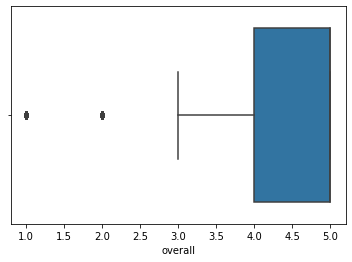

In [13]:
sns.boxplot(df['overall'])

<AxesSubplot:xlabel='overall', ylabel='Count'>

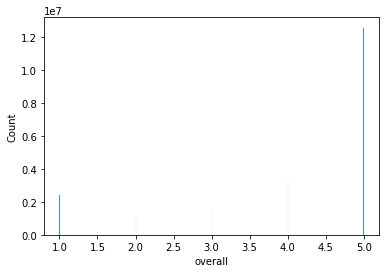

In [14]:
sns.histplot(df['overall'])

In [28]:
dfdata = df[['reviewText', 'overall']]
dfdata.head()

,reviewText,overall
0,This was the first time I read Garcia-Aguilera...,5
1,"As with all of Ms. Garcia-Aguilera's books, I ...",5
2,I've not read any of Ms Aguilera's works befor...,5
3,This romance novel is right up there with the ...,4
4,Carolina Garcia Aguilera has done it again. S...,5


In [29]:
dfdata.isnull().sum()

reviewText    9670
overall          0
dtype: int64

In [30]:
dfdata = dfdata[(~dfdata.isnull().any(axis=1)) & (dfdata.reviewText.apply(lambda x: str(x).strip() != ""))]

In [31]:
dfdata.isnull().sum()

reviewText    0
overall       0
dtype: int64

In [35]:
target_n = 500 * 1000
dfdataMain, _ = train_test_split(dfdata, train_size=target_n / dfdata.shape[0], stratify=dfdata['overall'], random_state=123)

In [36]:
dfdataMain.shape

(500000, 2)

In [38]:
# for training & testing
target_n = 480 * 1000
dfdataTrain, dfdataTest = train_test_split(dfdataMain, train_size=target_n / dfdataMain.shape[0], stratify=dfdataMain['overall'], random_state=123)

In [39]:
# for validation
target_n = 48 * 1000
dfdataValid, dfdataTrainSub = train_test_split(dfdataTrain, train_size=target_n / dfdataTrain.shape[0], stratify=dfdataTrain['overall'], random_state=123)

In [40]:
# for validation training & testing
target_n = 45 * 1000
dfdataValidTrain, dfdataValidTest = train_test_split(dfdataValid, train_size=target_n / dfdataValid.shape[0], stratify=dfdataValid['overall'], random_state=123)

In [42]:
# update the dataset for training, to only use 1 & 5 as output
dfdataTrain = dfdataTrain[dfdataTrain['overall'].apply(lambda x: x in (1, 5))]
dfdataTrainSub = dfdataTrainSub[dfdataTrainSub['overall'].apply(lambda x: x in (1, 5))]
dfdataValidTrain = dfdataValidTrain[dfdataValidTrain['overall'].apply(lambda x: x in (1, 5))]

In [48]:
print((dfdataTrain.shape[0]/480000) * 100)
print((dfdataTrainSub.shape[0]/432000) * 100)
print((dfdataValidTrain.shape[0]/45000) * 100)

71.52395833333334
71.52407407407408
71.52444444444444


<AxesSubplot:xlabel='overall', ylabel='Count'>

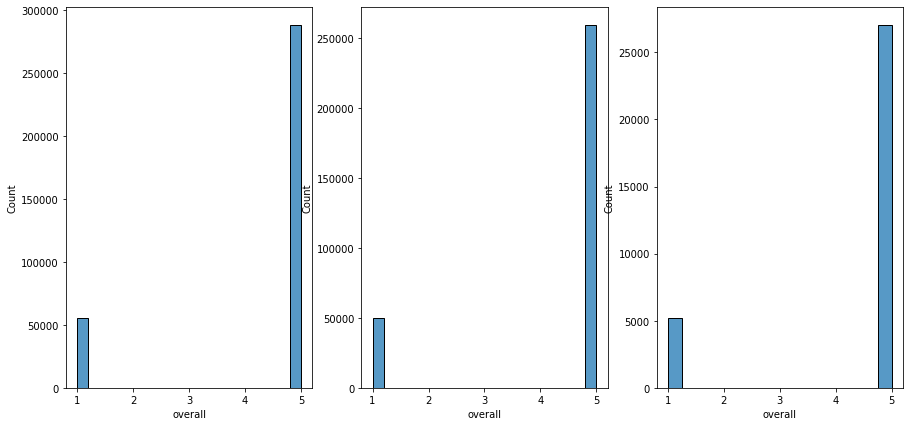

In [61]:
fig, axes = plt.subplots(figsize=(15,7), nrows=1, ncols=3)
sns.histplot(dfdataTrain['overall'], ax=axes[0])
sns.histplot(dfdataTrainSub['overall'], ax=axes[1])
sns.histplot(dfdataValidTrain['overall'], ax=axes[2])

In [62]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

238187138

In [63]:
# validation for processing

In [64]:
# upsampling minority group for validation training
if statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values) >= 10 * 1000:
    dfdataValidTrain = balancing_upsampling(dfdataValidTrain)

<AxesSubplot:xlabel='overall', ylabel='Count'>

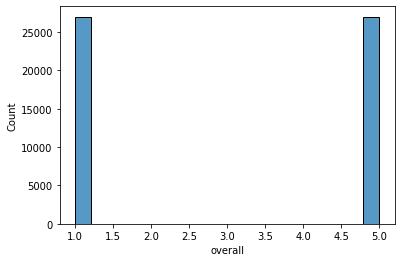

In [65]:
# sample resulf of sampling
sns.histplot(dfdataValidTrain['overall'])

In [66]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

0

In [67]:
mlp_model = MLPClassifier(verbose=True, early_stopping=True, tol=1e-5)

Iteration 1, loss = 0.66566150
Validation score: 0.889117
Iteration 2, loss = 0.50062813
Validation score: 0.917864
Iteration 3, loss = 0.32732978
Validation score: 0.903491
Iteration 4, loss = 0.19981850
Validation score: 0.915811
Iteration 5, loss = 0.12410114
Validation score: 0.917864
Iteration 6, loss = 0.08181139
Validation score: 0.913758
Iteration 7, loss = 0.05749460
Validation score: 0.913758
Iteration 8, loss = 0.04271325
Validation score: 0.913758
Iteration 9, loss = 0.03310731
Validation score: 0.917864
Iteration 10, loss = 0.02659296
Validation score: 0.909651
Iteration 11, loss = 0.02191835
Validation score: 0.909651
Iteration 12, loss = 0.01852968
Validation score: 0.911704
Iteration 13, loss = 0.01594969
Validation score: 0.911704
Validation score did not improve more than tol=0.000010 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.61862919
Validation score: 0.944502
Iteration 2, loss = 0.32735048
Validation score: 0.941418
Iteration 3, loss = 0.14222090
Va

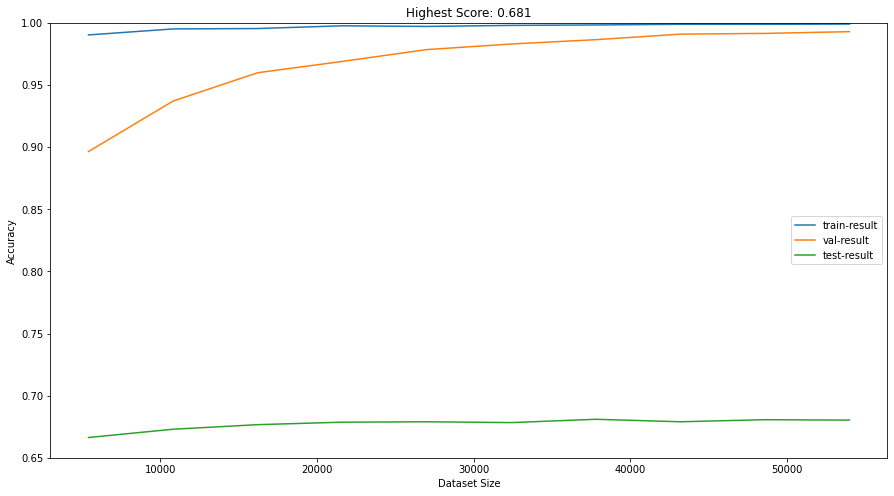

In [194]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 200000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(mlp_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

              precision    recall  f1-score   support

    Positive       0.97      0.89      0.93      2491
     Neutral       0.00      0.00      0.00         0
    Negative       0.74      0.74      0.74       509

    accuracy                           0.86      3000
   macro avg       0.57      0.54      0.56      3000
weighted avg       0.93      0.86      0.90      3000



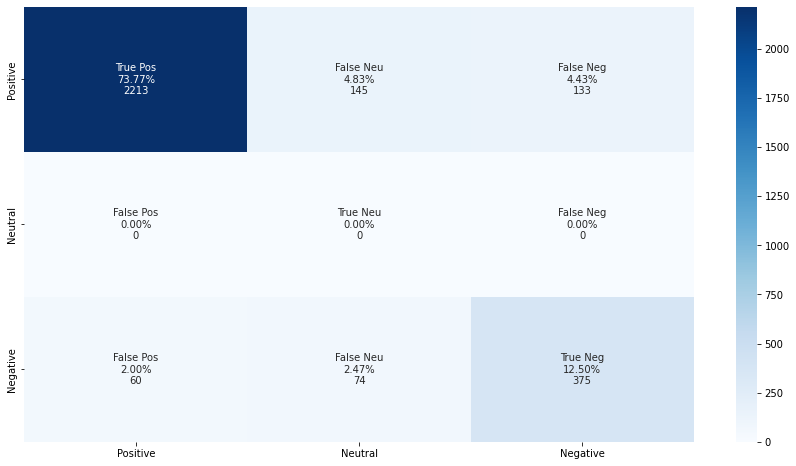

In [195]:
yHat = ['Negative' if x < 3 else 'Positive' if x > 3 else 'Neutral' for x in (mlp_model.predict_proba(testXArr)[:,1]/0.2)]
show_result(yHat, ['Negative' if x < 3 else 'Positive' if x > 3 else 'Neutral' for x in testYArr])

              precision    recall  f1-score   support

           5       0.97      0.73      0.83      2377
           4       0.06      0.26      0.10       114
           3       0.10      0.25      0.14        87
           2       0.12      0.24      0.16        84
           1       0.65      0.66      0.66       338

    accuracy                           0.68      3000
   macro avg       0.38      0.43      0.38      3000
weighted avg       0.85      0.68      0.75      3000



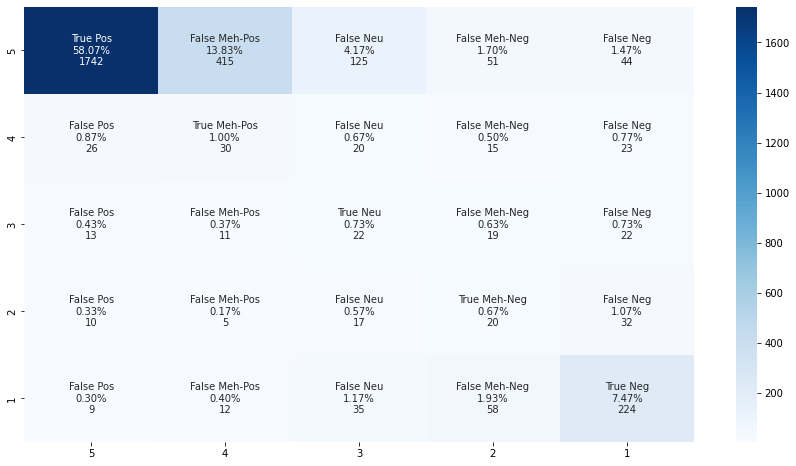

In [196]:
yHat = (mlp_model.predict_proba(testXArr)[:,1]//0.2)+1
show_result5group(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.98      0.96      0.97      1850
    Negative       0.78      0.91      0.84       295

    accuracy                           0.95      2145
   macro avg       0.88      0.93      0.90      2145
weighted avg       0.96      0.95      0.95      2145



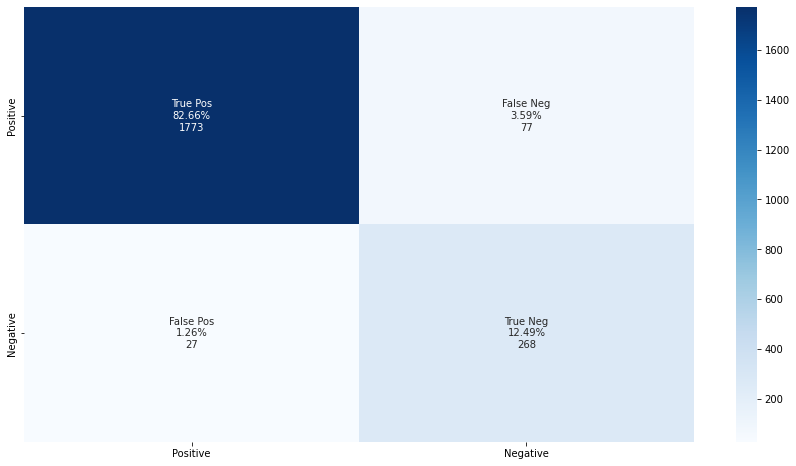

In [197]:
t = [x for x in zip(testXArr, testYArr) if x[1] in (1,5)]
yHat = ['Negative' if x == 1 else 'Positive' for x in mlp_model.predict(sp.sparse.vstack([x[0] for x in t]))]
show_result2group(yHat, ['Negative' if x == 1 else 'Positive' for x in [x[1] for x in t] if x in (1,5)])

In [198]:
# due to sparcity and possibility of bias in 1 < x < 5 group, we will use the binary output moving forward
# the accuracy on all output range also did not differ much from our previous model
# lets see the result on whole data with binary output

In [199]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataTrain.copy()
tdf2 = dfdataTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))

In [200]:
xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 200000)
yArr = tdf1['overall'].to_numpy()
t = tdf2[tdf2['overall'].apply(lambda x: x in (1, 5))]
testXArr, testYArr = featureModel.transform(t['reviewText']), t['overall'].to_numpy()

In [201]:
mlp_model = MLPClassifier(verbose=True, early_stopping=True, tol=1e-5)
mlp_model.fit(xArr, yArr)

Iteration 1, loss = 0.13211332
Validation score: 0.971543
Iteration 2, loss = 0.04269344
Validation score: 0.969620
Iteration 3, loss = 0.02367332
Validation score: 0.967640
Iteration 4, loss = 0.01776854
Validation score: 0.965659
Iteration 5, loss = 0.01929326
Validation score: 0.965280
Iteration 6, loss = 0.02044259
Validation score: 0.964610
Iteration 7, loss = 0.01736023
Validation score: 0.964261
Iteration 8, loss = 0.01610820
Validation score: 0.964698
Iteration 9, loss = 0.01654592
Validation score: 0.963212
Iteration 10, loss = 0.01610052
Validation score: 0.963999
Iteration 11, loss = 0.01473822
Validation score: 0.963503
Iteration 12, loss = 0.01412058
Validation score: 0.963067
Validation score did not improve more than tol=0.000010 for 10 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, tol=1e-05, verbose=True)

              precision    recall  f1-score   support

    Positive       0.99      0.98      0.98     12063
    Negative       0.90      0.92      0.91      2242

    accuracy                           0.97     14305
   macro avg       0.94      0.95      0.95     14305
weighted avg       0.97      0.97      0.97     14305



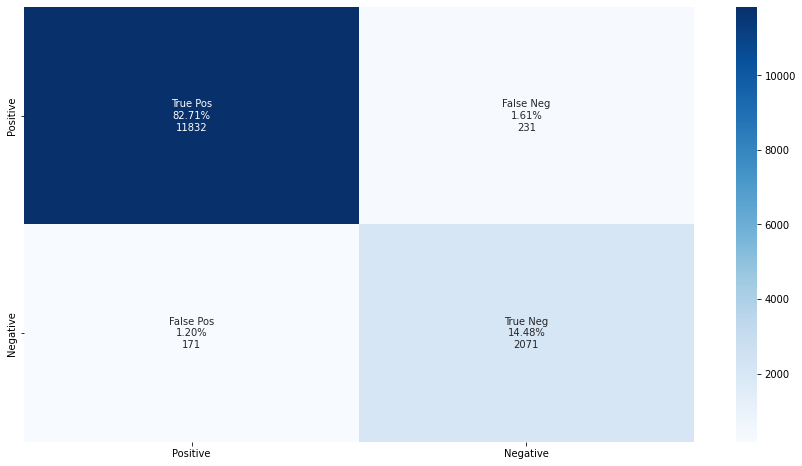

In [202]:
t = [x for x in zip(testXArr, testYArr) if x[1] in (1,5)]
yHat = ['Negative' if x == 1 else 'Positive' for x in mlp_model.predict(sp.sparse.vstack([x[0] for x in t]))]
show_result2group(yHat, ['Negative' if x == 1 else 'Positive' for x in [x[1] for x in t] if x in (1,5)])

In [203]:
# Performance looks better with 91% f-1 score on Negative labels
# Moving forward, we will only target binary output (1 & 5)